In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder


In [3]:
train_dataset = pd.read_csv('train_cleandata.csv')

In [4]:
test_dataset = pd.read_csv('test_cleandata.csv')

In [5]:
print(train_dataset)

           date  quarter department        day  team  targeted_productivity  \
0    2015-03-11        2     sewing  Wednesday     8                   0.70   
1    2015-02-02        1  finishing     Monday     1                   0.75   
2    2015-01-05        1  finishing     Monday    10                   0.75   
3    2015-02-12        2  finishing   Thursday     4                   0.70   
4    2015-01-08        2     sewing   Thursday    12                   0.80   
..          ...      ...        ...        ...   ...                    ...   
952  2015-03-03        1  finishing    Tuesday     5                   0.70   
953  2015-03-07        1  finishing   Saturday     6                   0.50   
954  2015-03-09        2  finishing     Monday     5                   0.60   
955  2015-02-19        3     sewing   Thursday     7                   0.75   
956  2015-03-08        2  finishing     Sunday    10                   0.70   

       smv    wip  over_time  incentive  idle_time 

In [5]:
# Load data
train_set = pd.read_csv("train_cleandata.csv")
test_set = pd.read_csv("test_cleandata.csv")

# Convert categorical variables to categorical dtype
categorical_cols = ["quarter", "day", "team", "department", "month"]
train_set[categorical_cols] = train_set[categorical_cols].astype("category")
test_set[categorical_cols] = test_set[categorical_cols].astype("category")

# Define predictors
department_predictors = [
    "targeted_productivity", "smv", "over_time", "incentive",
    "idle_time", "idle_men", "no_of_workers", "team", "month"
]

department_predictors_finishing = [
    "targeted_productivity", "smv", "over_time", "no_of_workers", "team", "month"
]

overall_predictors = department_predictors + ["department"]
# Train and evaluate XGBoost model
def train_evaluate_xgb(train_data, test_data, department_name, predictors):
    
    # Select features and target
    X_train = train_data[predictors]
    X_test = test_data[predictors]
    y_train = train_data["actual_productivity"]
    y_test = test_data["actual_productivity"]

    # Convert to DMatrix with categorical support
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

    # Define parameter grid
    param_grid = {
        "eta": [0.05, 0.1],
        "max_depth": [2, 3],
        "gamma": [0, 0.1],
        "subsample": [0.8, 1],
        "colsample_bytree": [0.8, 1],
        "min_child_weight": [5, 7],
        "lambda": np.linspace(0, 0.1, 1),
        "alpha": np.linspace(0, 0.1, 1)
    }

    # Hyperparameter tuning
    best_params = None
    best_rmse = float("inf")
    best_num_rounds = 0
    
    for eta in param_grid["eta"]:
        for max_depth in param_grid["max_depth"]:
            for gamma in param_grid["gamma"]:
                for subsample in param_grid["subsample"]:
                    for colsample_bytree in param_grid["colsample_bytree"]:
                        for min_child_weight in param_grid["min_child_weight"]:
                            for lmbd in param_grid["lambda"]:
                                for alpha in param_grid["alpha"]:
                                    params = {
                                        "eta": eta,
                                        "max_depth": max_depth,
                                        "gamma": gamma,
                                        "subsample": subsample,
                                        "colsample_bytree": colsample_bytree,
                                        "min_child_weight": min_child_weight,
                                        "lambda": lmbd,
                                        "alpha": alpha,
                                        "objective": "reg:squarederror",
                                        "eval_metric": "rmse"
                                    }
                                    
                                    cv_results = xgb.cv(
                                        params, dtrain, num_boost_round=1000, nfold=5,
                                        early_stopping_rounds=10, verbose_eval=False
                                    )
                                    
                                    # Find the best iteration
                                    if not cv_results.empty:
                                        best_iter = cv_results["test-rmse-mean"].idxmin()
                                        current_num_rounds = best_iter + 1
                                        mean_rmse = cv_results["test-rmse-mean"].iloc[best_iter]
                                        
                                        if mean_rmse < best_rmse:
                                            best_rmse = mean_rmse
                                            best_params = params
                                            best_num_rounds = current_num_rounds

    # Train final model with best parameters and rounds
    final_model = xgb.train(best_params, dtrain, num_boost_round=best_num_rounds)

    # Feature importance
    importance = final_model.get_score(importance_type="gain")
    importance_df = pd.DataFrame(list(importance.items()), columns=["Feature", "Gain"]).sort_values(by="Gain", ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Gain"], color="steelblue")
    plt.xlabel("Gain")
    plt.ylabel("Features")
    plt.title(f"{department_name} - Feature Importance XGBoost")
    plt.gca().invert_yaxis()
    plt.show()

    # Predictions
    train_pred = final_model.predict(dtrain)
    test_pred = final_model.predict(dtest)

    # Metrics
    metrics = {
        "best_params": best_params,
        "best_num_rounds": best_num_rounds,
        "train_mse": mean_squared_error(y_train, train_pred),
        "test_mse": mean_squared_error(y_test, test_pred),
        "train_r2": r2_score(y_train, train_pred),
        "test_r2": r2_score(y_test, test_pred)
    }

    return metrics

# Department-wise training
sewing_train = train_set[train_set["department"] == "sewing"]
sewing_test = test_set[test_set["department"] == "sewing"]

finishing_train = train_set[train_set["department"] == "finishing"]
finishing_test = test_set[test_set["department"] == "finishing"]

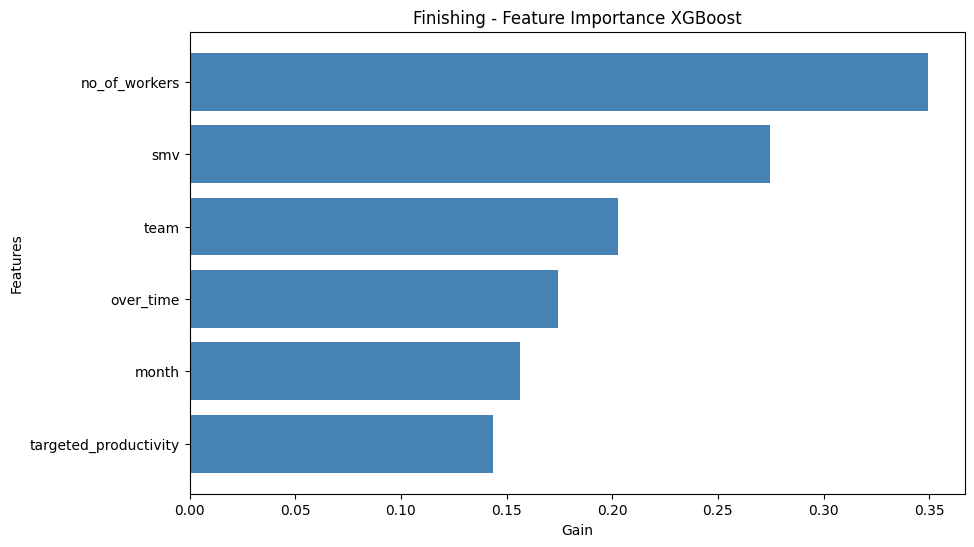

  Department  Best Eta  Best Depth  Best Rounds  Train MSE  Test MSE  \
0  Finishing      0.05           2           99   0.022601  0.028571   

   Train R²   Test R²  
0  0.415077  0.183617  


In [8]:
finishing_metrics = train_evaluate_xgb(finishing_train, finishing_test, "Finishing", department_predictors)
print(pd.DataFrame([
    #{
    #    "Department": "Sewing",
    #    "Best Eta": sewing_metrics["best_params"]["eta"],
    #    "Best Depth": sewing_metrics["best_params"]["max_depth"],
    #    "Best Rounds": sewing_metrics["best_num_rounds"],
    #    "Train MSE": sewing_metrics["train_mse"],
    #    "Test MSE": sewing_metrics["test_mse"],
    #    "Train R²": sewing_metrics["train_r2"],
    #    "Test R²": sewing_metrics["test_r2"]
    #}
    # Uncomment below for Finishing and Overall models
    #,
    {
        "Department": "Finishing",
        "Best Eta": finishing_metrics["best_params"]["eta"],
        "Best Depth": finishing_metrics["best_params"]["max_depth"],
        "Best Rounds": finishing_metrics["best_num_rounds"],
        "Train MSE": finishing_metrics["train_mse"],
        "Test MSE": finishing_metrics["test_mse"],
        "Train R²": finishing_metrics["train_r2"],
        "Test R²": finishing_metrics["test_r2"]
    },
    # {
    #     "Department": "Overall",
    #     "Best Eta": overall_metrics["best_params"]["eta"],
    #     "Best Depth": overall_metrics["best_params"]["max_depth"],
    #     "Best Rounds": overall_metrics["best_num_rounds"],
    #     "Train MSE": overall_metrics["train_mse"],
    #     "Test MSE": overall_metrics["test_mse"],
    #     "Train R²": overall_metrics["train_r2"],
    #     "Test R²": overall_metrics["test_r2"]
    # }
]))

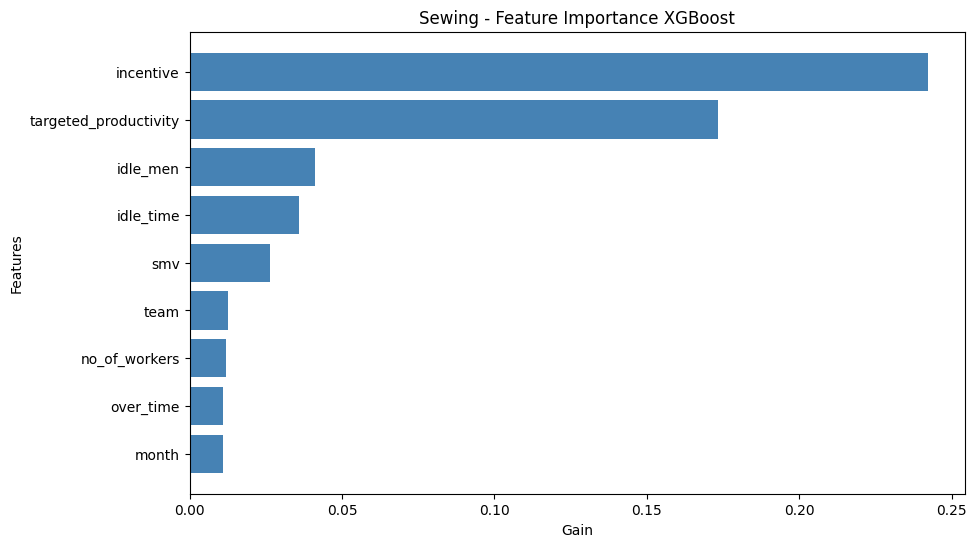

  Department  Best Eta  Best Depth  Best Rounds  Train MSE  Test MSE  \
0     Sewing       0.1           2          242   0.002027  0.004154   

   Train R²   Test R²  
0  0.917729  0.798131  


In [9]:
# Train models
sewing_metrics = train_evaluate_xgb(sewing_train, sewing_test, "Sewing", department_predictors)
# finishing_metrics = train_evaluate_xgb(finishing_train, finishing_test, "Finishing", department_predictors)

# Overall model training
# overall_metrics = train_evaluate_xgb(train_set, test_set, "Overall", overall_predictors)

# Print results
print(pd.DataFrame([
    {
        "Department": "Sewing",
        "Best Eta": sewing_metrics["best_params"]["eta"],
        "Best Depth": sewing_metrics["best_params"]["max_depth"],
        "Best Rounds": sewing_metrics["best_num_rounds"],
        "Train MSE": sewing_metrics["train_mse"],
        "Test MSE": sewing_metrics["test_mse"],
        "Train R²": sewing_metrics["train_r2"],
        "Test R²": sewing_metrics["test_r2"]
    }
    # Uncomment below for Finishing and Overall models
    # ,
    # {
    #     "Department": "Finishing",
    #     "Best Eta": finishing_metrics["best_params"]["eta"],
    #     "Best Depth": finishing_metrics["best_params"]["max_depth"],
    #     "Best Rounds": finishing_metrics["best_num_rounds"],
    #     "Train MSE": finishing_metrics["train_mse"],
    #     "Test MSE": finishing_metrics["test_mse"],
    #     "Train R²": finishing_metrics["train_r2"],
    #     "Test R²": finishing_metrics["test_r2"]
    # },
    # {
    #     "Department": "Overall",
    #     "Best Eta": overall_metrics["best_params"]["eta"],
    #     "Best Depth": overall_metrics["best_params"]["max_depth"],
    #     "Best Rounds": overall_metrics["best_num_rounds"],
    #     "Train MSE": overall_metrics["train_mse"],
    #     "Test MSE": overall_metrics["test_mse"],
    #     "Train R²": overall_metrics["train_r2"],
    #     "Test R²": overall_metrics["test_r2"]
    # }
]))

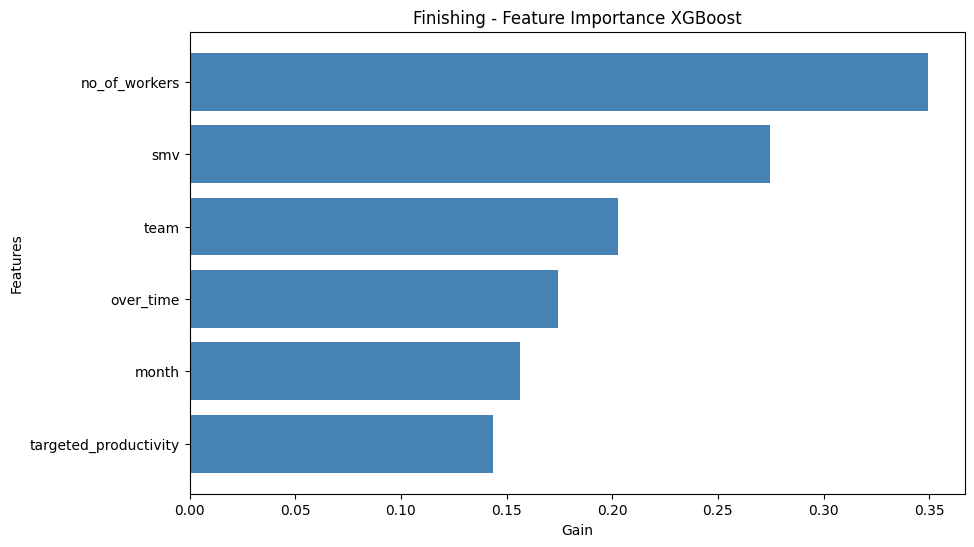

  Department  Best Eta  Best Depth  Best Rounds  Train MSE  Test MSE  \
0  Finishing      0.05           2           99   0.022601  0.028571   

   Train R²   Test R²  
0  0.415077  0.183617  


In [6]:
finishing_metrics = train_evaluate_xgb(finishing_train, finishing_test, "Finishing", department_predictors_finishing)
print(pd.DataFrame([
    #{
    #    "Department": "Sewing",
    #    "Best Eta": sewing_metrics["best_params"]["eta"],
    #    "Best Depth": sewing_metrics["best_params"]["max_depth"],
    #    "Best Rounds": sewing_metrics["best_num_rounds"],
    #    "Train MSE": sewing_metrics["train_mse"],
    #    "Test MSE": sewing_metrics["test_mse"],
    #    "Train R²": sewing_metrics["train_r2"],
    #    "Test R²": sewing_metrics["test_r2"]
    #}
    # Uncomment below for Finishing and Overall models
    #,
    {
        "Department": "Finishing",
        "Best Eta": finishing_metrics["best_params"]["eta"],
        "Best Depth": finishing_metrics["best_params"]["max_depth"],
        "Best Rounds": finishing_metrics["best_num_rounds"],
        "Train MSE": finishing_metrics["train_mse"],
        "Test MSE": finishing_metrics["test_mse"],
        "Train R²": finishing_metrics["train_r2"],
        "Test R²": finishing_metrics["test_r2"]
    },
    # {
    #     "Department": "Overall",
    #     "Best Eta": overall_metrics["best_params"]["eta"],
    #     "Best Depth": overall_metrics["best_params"]["max_depth"],
    #     "Best Rounds": overall_metrics["best_num_rounds"],
    #     "Train MSE": overall_metrics["train_mse"],
    #     "Test MSE": overall_metrics["test_mse"],
    #     "Train R²": overall_metrics["train_r2"],
    #     "Test R²": overall_metrics["test_r2"]
    # }
]))

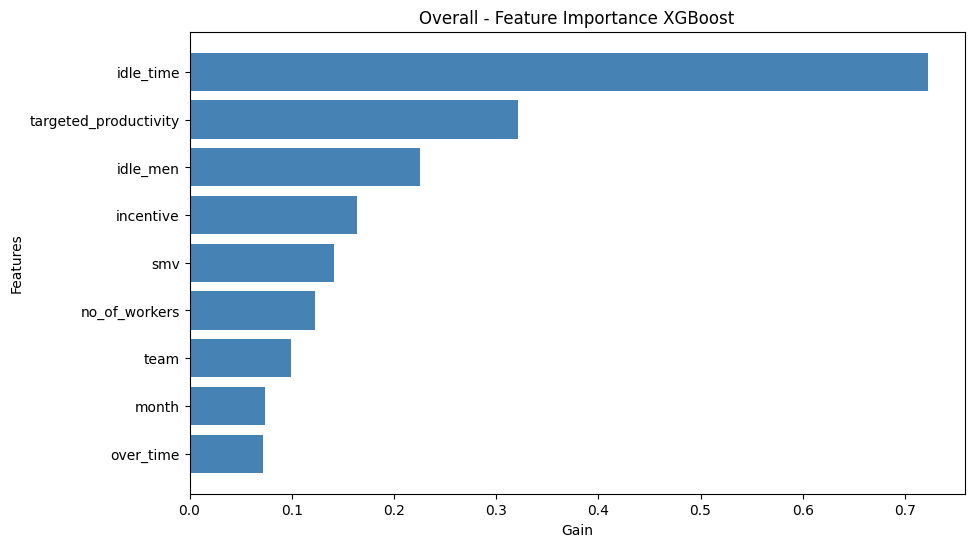

  Department  Best Eta  Best Depth  Best Rounds  Train MSE  Test MSE  \
0    Overall       0.1           3          114   0.010072  0.013845   

   Train R²   Test R²  
0   0.67408  0.476151  


In [14]:
overall_metrics = train_evaluate_xgb(train_set, test_set, "Overall", overall_predictors)
print(pd.DataFrame([
    #{
    #    "Department": "Sewing",
    #    "Best Eta": sewing_metrics["best_params"]["eta"],
    #    "Best Depth": sewing_metrics["best_params"]["max_depth"],
    #    "Best Rounds": sewing_metrics["best_num_rounds"],
    #    "Train MSE": sewing_metrics["train_mse"],
    #    "Test MSE": sewing_metrics["test_mse"],
    #    "Train R²": sewing_metrics["train_r2"],
    #    "Test R²": sewing_metrics["test_r2"]
    #}
    # Uncomment below for Finishing and Overall models
    #,
    #{
    #    "Department": "Finishing",
    #    "Best Eta": finishing_metrics["best_params"]["eta"],
    #    "Best Depth": finishing_metrics["best_params"]["max_depth"],
    #    "Best Rounds": finishing_metrics["best_num_rounds"],
    #    "Train MSE": finishing_metrics["train_mse"],
    #    "Test MSE": finishing_metrics["test_mse"],
    #    "Train R²": finishing_metrics["train_r2"],
    #    "Test R²": finishing_metrics["test_r2"]
    #},
     {
         "Department": "Overall",
         "Best Eta": overall_metrics["best_params"]["eta"],
         "Best Depth": overall_metrics["best_params"]["max_depth"],
         "Best Rounds": overall_metrics["best_num_rounds"],
         "Train MSE": overall_metrics["train_mse"],
         "Test MSE": overall_metrics["test_mse"],
         "Train R²": overall_metrics["train_r2"],
         "Test R²": overall_metrics["test_r2"]
     }
]))